In [1]:
# In case you are already running a program with a GPU locally

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [2]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
from keras.datasets import cifar10
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Input, Concatenate, InputLayer, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.utils import np_utils, to_categorical
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from numpy.random import shuffle
from numpy import asarray
from numpy.random import randn
import pickle
from random import shuffle
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### Path Variables and Directories

In [3]:
generator_path = os.getcwd()+"/Model/Generator"
discriminator_path = os.getcwd()+"/Model/Discriminator"
image_path = os.getcwd()+"/Images"
if not os.path.exists(generator_path) and not os.path.exists(discriminator_path):
    os.makedirs(generator_path)
    os.makedirs(discriminator_path)
    f= open("fid.csv","a")
    f.close()
if not os.path.exists(image_path):
    os.makedirs(image_path)

### Custom Attention Layer Implementation

In [4]:
from keras import backend as K
from keras.layers import Layer
from keras.engine import InputSpec

class Attention(Layer):
    def __init__(self, ch=64, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map
       
        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
img_rows = 32
img_cols = 32
channels = 3

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Label Inputs to GAN
labels = Input(shape=(10,))
num_classes = 10



### Generator 

In [6]:
def build_generator(z_dim):

    z = Input(shape=(100,))

    labels = Input(shape=(10,))

    merged_layer = Concatenate()([z, labels])

    generator = Dense(4*4*256, activation='relu')(merged_layer)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = Reshape((4, 4, 256))(generator)

    generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)

    generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = Attention(ch=64)(generator)
    
    generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

    generator = Model(inputs=[z, labels], outputs=generator, name='generator')
    
    return generator

### Discriminator 

In [7]:
def build_discriminator():

    img_input = Input(shape=img_shape)

    discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Attention(ch=64)(discriminator)
    discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Flatten()(discriminator)

    merged_layer = Concatenate()([discriminator, labels])
    discriminator = Dense(128, activation='relu')(merged_layer)

    discriminator = Dense(1, activation='sigmoid')(discriminator)

    discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')
    
    return discriminator

In [8]:
def build_gan(g_model, d_model):
    discriminator.trainable = False

    label = Input(shape=(10,), name='label')
    z = Input(shape=(100,), name='z')

    fake_img = generator([z, label])
    validity = discriminator([fake_img, label])

    gan = Model([z, label], validity, name='GAN')

    return gan

### Model

In [9]:
from os import listdir
from os.path import isfile, join
import re 
    
if(len(listdir(generator_path)) > 0 and len(listdir(discriminator_path))>0):
    print("Loading existing models.")
    
    gen_files = [f for f in listdir(generator_path) if isfile(join(generator_path, f))]
    disc_files = [f for f in listdir(discriminator_path) if isfile(join(discriminator_path, f))]
    
    def extract_number(f):
        s = re.findall("\d+$",f)
        return (int(s[0]) if s else -1,f)

    print("Generator Model: "+max(gen_files,key=extract_number))
    print("Discriminator Model: "+max(disc_files,key=extract_number))
    
    gen_file = max(gen_files,key=extract_number)
    disc_file = max(disc_files, key=extract_number)
    discriminator = keras.models.load_model(discriminator_path+"/"+disc_file, custom_objects={"Attention" : Attention})
    discriminator.compile(optimizer = Adam(0.0004), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    generator = keras.models.load_model(generator_path+"/"+gen_file ,custom_objects={"Attention" : Attention})
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))
else:
    # Build and compile the Discriminator
    print("Creating new models")
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0004),
                          metrics=['accuracy'])

    # Build the Generator
    generator = build_generator(z_dim)
    
    # Keep Discriminator’s parameters constant for Generator training
    discriminator.trainable = False
    
    # Build and compile GAN model with fixed Discriminator to train the Generator
    gan = build_gan(generator, discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))
    #gan.summary()
    
    

Loading existing models.
Generator Model: generator_0339.h5
Discriminator Model: discriminator_0339.h5




(1, 1, 64, 8)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(1, 1, 64, 8)


C:\Users\argad\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
plot_model(generator, to_file='gen_plot.png', show_shapes=True, show_layer_names=True)
#SVG(model_to_dot(generator).create(prog='dot', format='svg'))
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 110)          0           input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 4096)         454656      concatenate_17[0][0]             
__________

In [11]:
plot_model(discriminator, to_file='disc_plot.png', show_shapes=True, show_layer_names=True)
#SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 64)   4864        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 16, 16, 64)   256         conv2d_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_38 (LeakyReLU)      (None, 16, 16, 64)   0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
attention_

C:\Users\argad\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Total params: 2,531,364
Trainable params: 1,265,490
Non-trainable params: 1,265,874
__________________________________________________________________________________________________


In [12]:
plot_model(gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
#SVG(model_to_dot(gan).create(prog='dot', format='svg'))
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    1506004     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1265874     generator[1][0]                  
          

### Data Preprocessing

Training shape: (50000, 32, 32, 3)
Range of Training Images: -1.0 1.0
Range of Testing Images: -1.0 1.0
Range of Training Images: -1.0 1.0


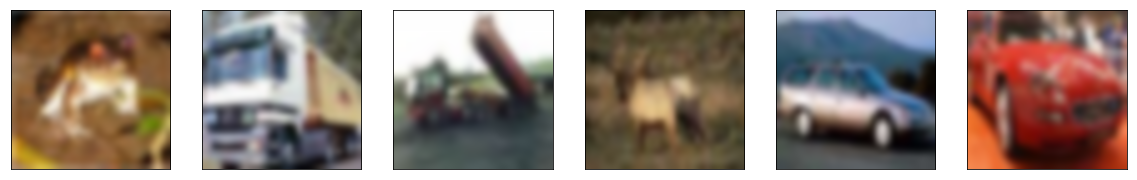

In [13]:
batch_size = 64

# # Get training images
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# check some images
fig, axes = plt.subplots(figsize=(20, 4), nrows=1, ncols=6, sharey=True, sharex=False)
for i in range(6):
    axes[i].xaxis.set_visible(False)
    axes[i].yaxis.set_visible(False)
    im = axes[i].imshow(train_images[i],interpolation='bicubic')

train_images = np.float32(train_images)
train_images = (train_images - 127.5) / 127.5



test_images = np.float32(test_images)
test_images = (test_images - 127.5) / 127.5

print ("Training shape: {}".format(train_images.shape))
print("Range of Training Images: {} {}".format(np.min(train_images),np.max(train_images)))
print("Range of Testing Images: {} {}".format(np.min(test_images),np.max(test_images)))
# Normalize data
print("Range of Training Images: {} {}".format(np.min(train_images),np.max(train_images)))
num_batches = int(train_images.shape[0]/batch_size)

fid_list = []


### Image Generation

In [14]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_imgs(epoch):
    z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
    fake_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
    gen_imgs = generator.predict_on_batch([z, fake_labels])

    fig, axs = plt.subplots(3, 3)
    count = 0
    for i in range(3):
        for j in range(3):
      # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            count += 1
    plt.savefig(fname=image_path+'/image_at_epoch_{:04d}.png'.format(epoch)) 
    plt.show()
    plt.close()

### FID Calculation

In [15]:
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

# compute the FID scores
def compute_fid(generator, z, fake_labels, epoch):
    predictions = generator.predict_on_batch([z, fake_labels])
    #predictions_fid = ((predictions[:, :, :, :] * 127.5 + 127.5))
    predictions_fid = predictions.astype('float32')
    predictions_fid = scale_images(predictions_fid , (299,299,3))
    print('Calculating the FID Score...')
    
    # pre-process images
    #predictions_fid = preprocess_input(predictions_fid)
    print("Range of Generated Images: {} {}".format(np.min(predictions),np.max(predictions)))
    print(predictions_fid.shape)
    #test_images_fid1 = preprocess_input(test_images_fid)
    print("Range of Test Images: {} {}".format(np.min(test_images_fid),np.max(test_images_fid)))
    print(test_images_fid.shape)
    # calculate fid
    fid = calculate_fid(model_fid, predictions_fid, test_images_fid)
    print('FID: %.3f' % fid)
    
    return fid

test_images_fid = test_images[:1000,:]
test_images_fid = test_images_fid.astype('float32')
test_images_fid = scale_images(test_images_fid, (299,299,3))

model_fid = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights='imagenet')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Training Cell

In [16]:
def train():
    gen_losses = []
    disc_losses = []
    N_EPOCHS = 250
    smooth = 0.1

    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))

    for epoch in tqdm(range(N_EPOCHS)):

        epoch+=244

        cum_d_loss = 0.
        cum_g_loss = 0.
        g_loss = 0
        d_loss = 0
        for batch_idx in tqdm(range(num_batches)):

            # Real Samples
            images = train_images[batch_idx*batch_size : (batch_idx+1)*batch_size]
            real_labels = to_categorical(train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(-1, 1), num_classes=10)
            #print(real.shape)
            d_loss_real = discriminator.train_on_batch(x=[images, real_labels],y=real * (1 - smooth))

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
            fake_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
            fake_images = generator.predict_on_batch([z, fake_labels])

            d_loss_fake = discriminator.train_on_batch(x=[fake_images, fake_labels], y=fake)

            # Discriminator loss
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            cum_d_loss += d_loss

            # Train generator
            g_loss = gan.train_on_batch(x=[z, fake_labels], y=real)

            gen_losses.append(g_loss)
            disc_losses.append(d_loss)

            cum_g_loss += g_loss


        print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
        show_imgs(epoch)
        #print(' Accuracy: {}'.format(accuracy))

        if (epoch+1) % 5 == 0:

            z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
            fake_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
            current_fid = compute_fid(generator, z, fake_labels, epoch)

            fid_list.append((epoch,current_fid))
            row = [epoch, current_fid, g_loss, d_loss]
            with open('fid.csv', 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerow(row)
            print("Saving Models")
            discriminator.trainable = True
            generator.save(generator_path+"/generator_{:04d}.h5".format(epoch))
            discriminator.save(discriminator_path+"/discriminator_{:04d}.h5".format(epoch))
            discriminator.trainable = False
            #discriminator.summary()
            #discriminator.compile(optimizer = Adam(0.0004), loss='binary_crossentropy', metrics=['accuracy'])
            gan = build_gan(generator, discriminator)
            gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001))

In [17]:
df = pd.read_csv("fid.csv", skip_blank_lines=True)
df.head()

,Epoch,FID,Gen_Loss,Disc_Loss
0,4,299.799301,5.157332,0.295869
1,9,267.969475,10.386825,0.170779
2,14,243.660364,6.159948,0.186864
3,19,256.270078,6.354544,0.257640
4,24,236.539317,7.829272,0.222627


### Generator and Discriminator Losses

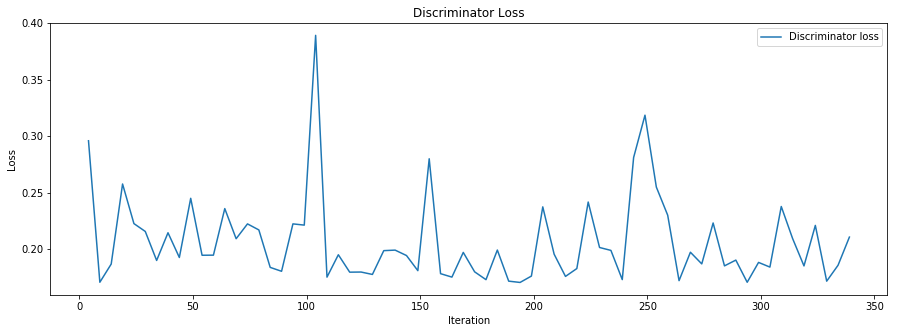

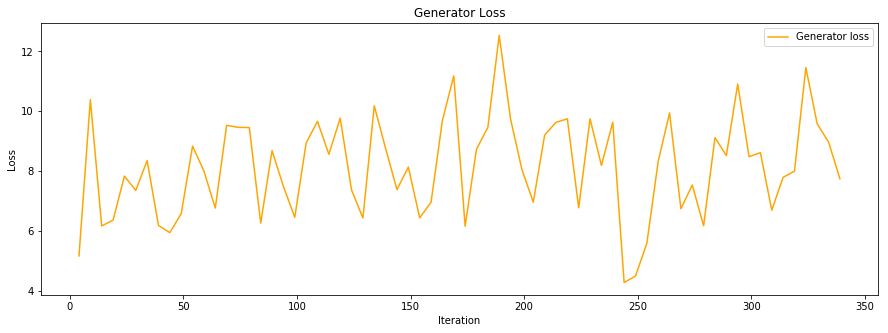

In [18]:
gen_losses = np.array(df["Gen_Loss"])
disc_losses = np.array(df["Disc_Loss"])
epoch_list = np.array(df["Epoch"])
# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(epoch_list, disc_losses, label="Discriminator loss")
plt.title("Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(epoch_list, gen_losses, label="Generator loss", color="orange")

plt.title("Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

### FID Scores

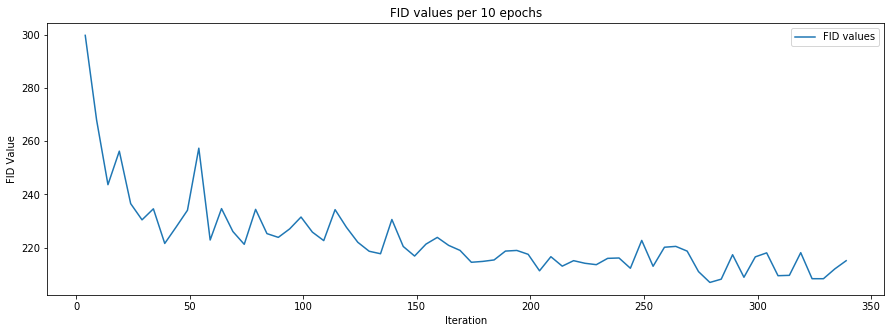

In [19]:
fid_list = np.array(df["FID"])

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(epoch_list,fid_list, label="FID values")


#plt.xticks(fid_list.T[0], rotation=90)

plt.title("FID values per 10 epochs")
plt.xlabel("Iteration")
plt.ylabel("FID Value")
plt.legend()

In [20]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

### Generate 8x8 Grid

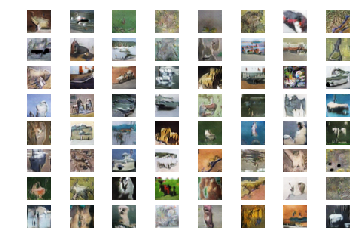

In [21]:
# load model
# model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
fake_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
X = generator.predict_on_batch([z, fake_labels])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 8)

### Generate Single Image 

(1, 100)


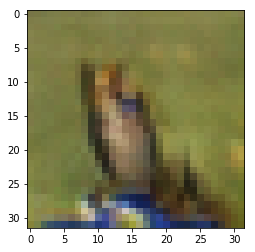

In [41]:
vector = generate_latent_points(100, 1)
print(vector.shape)
# generate image
z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
fake_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
X = generator.predict_on_batch([z, fake_labels])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plt.imshow(X[0, :, :])
plt.show()